# SG MCMC Quantization

In [1]:
from jax import vmap, value_and_grad
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
from stein_thinning.stein import ksd, kmat
from stein_thinning.thinning import thin
from stein_thinning.kernel import make_imq, make_precon

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

mu = jnp.zeros([2,])
r = np.pi / 4
D = jnp.array([2.0, 1.0])
P = jnp.array([[jnp.cos(r), jnp.sin(r)], [-jnp.sin(r), jnp.cos(r)]])
sigma = P.T @ jnp.diag(D) @ P

In [3]:
N = 1_000
disp = [1 / 5, 1, 3]
rng = np.random.default_rng(0)
samples = np.array([rng.multivariate_normal(mu, sigma**d, size=N) for d in disp])

In [4]:
def plot_samples(samples):
    titles = ["$\sqrt[5]{\Sigma}$", "$\Sigma$", "$\Sigma^{3}$"]
    _, axs = plt.subplots(1, len(samples), sharey=True, figsize=(12, 4))
    for i, ax in enumerate(axs.flatten()):
        ax.axis("equal")
        ax.grid()
        ax.scatter(samples[i, :, 0], samples[i, :, 1], alpha=0.3)
        for std in range(1, 4):
            conf_ell = Ellipse(
                xy=mu,
                width=D[0] * std,
                height=D[1] * std,
                angle=np.rad2deg(r),
                edgecolor="black",
                linestyle="--",
                facecolor="none",
            )
            ax.add_artist(conf_ell)
        ax.set_title(titles[i])
    plt.show()

In [5]:
def quantization(x, s, z, alpha_q, beta_q):
    x_q = np.round(1 / s * x + z, decimals=0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)
    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(np.int8)
    return x_q

def dequantization(x_q, s, z):
    # x_q - z might go outside the quantization range.
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float64)
    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1
    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)
    return s, z

In [7]:
def sgmcmc_diagnostic(samples,mu,sigma):
    logpdf = lambda params: stats.multivariate_normal.logpdf(params, mu, sigma)
    _, grads = vmap(vmap(value_and_grad(logpdf), 0, 0), 1, 1)(samples)
    numpy_grads=np.array(grads)
    ksd_samples=list()
    for i in range(samples.shape[0]):
        vfk0 = make_imq(samples[i,:],numpy_grads[i,:], pre='sclmed')
        ks_smp=ksd(samples[i,:],numpy_grads[i,:],vfk0)
        ksd_samples.append(np.sqrt(np.sum(ks_smp))/len(ks_smp))
    log_ksd = np.log10(ksd_samples)
    return log_ksd

def quantize_samples(samples):
    s=list()
    z=list()
    q_samples=np.zeros_like(samples).astype(np.int8)
    for i in range(samples.shape[0]):
        alpha=np.min(samples[i,:])
        beta=np.max(samples[i,:])
        ss,zz=generate_quantization_int8_constants(alpha,beta)
        x_q=quantization_int8(samples[i,:],ss,zz)
        q_samples[i,:]=x_q
        s.append(ss)
        z.append(zz)
    return q_samples,s,z

def dequantizate_samples(q_samples,s,z):
    samples=np.zeros_like(q_samples).astype(np.float16)
    for i in range(q_samples.shape[0]):
        samples[i,:]=dequantization(q_samples[i,:], s[i], z[i])
    return samples

ksd_float64=sgmcmc_diagnostic(samples,mu,sigma)
ksd_float16=sgmcmc_diagnostic(samples.astype(np.float16),mu,sigma)

q_samples,s,z=quantize_samples(samples)
r_samples=dequantizate_samples(q_samples,s,z)
ksd_int8=sgmcmc_diagnostic(r_samples,mu,sigma)

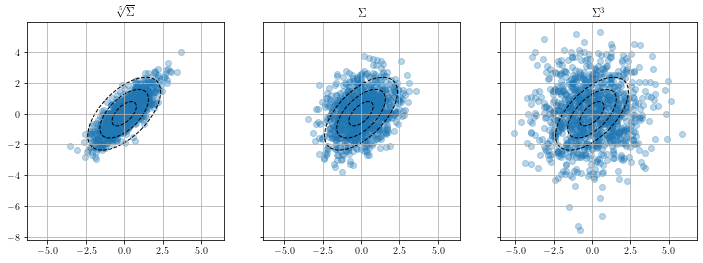

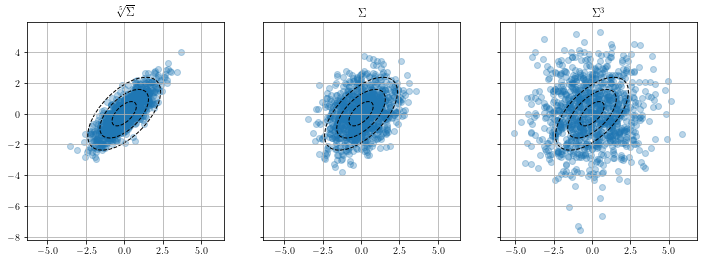

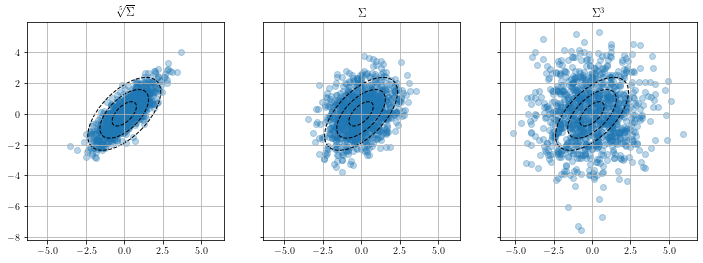

In [8]:
plot_samples(samples)
plot_samples(samples.astype(np.float16))
plot_samples(r_samples)

In [9]:
import pandas as pd

ksd_precisions=np.stack([ksd_float64,ksd_float16,ksd_int8])
df=pd.DataFrame({'underdispersed':ksd_precisions[:,0],
                'not biased':ksd_precisions[:,1],
                'overdispersed':ksd_precisions[:,2]},
                index=['Float64','Float16','Int8'])

Text(0, 0.5, 'Log KSD')

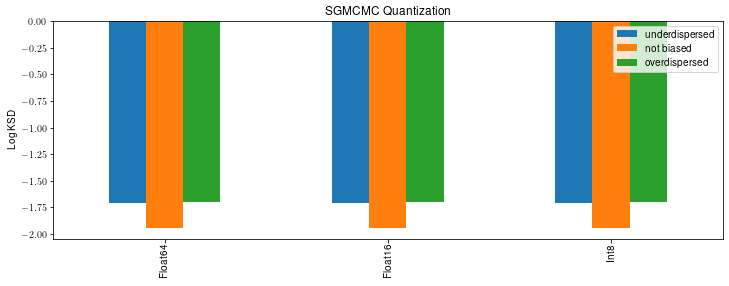

In [10]:
df.plot(kind="bar",figsize=(12, 4))
plt.title("SGMCMC Quantization")
plt.ylabel("Log KSD")

In [11]:
def sgmcmc_thinning(samples,mu,sigma,num_points=500):
    logpdf = lambda params: stats.multivariate_normal.logpdf(params, mu, sigma)
    _, grads = vmap(vmap(value_and_grad(logpdf), 0, 0), 1, 1)(samples)
    numpy_grads=np.array(grads)
    thinned_samples=list()
    for i in range(samples.shape[0]):
        idx=thin(samples[i,:],numpy_grads[i,:], num_points)
        thinned_samples.append(samples[i,idx])
    return np.stack(thinned_samples)

In [12]:
thinned_samples=sgmcmc_thinning(samples,mu,sigma,500)
thinned_samples_f16=sgmcmc_thinning(samples.astype(np.float16),mu,sigma,500)
thinned_samples_int8=sgmcmc_thinning(r_samples,mu,sigma,500)

In [13]:
thinned_size_f64=thinned_samples.nbytes
thinned_size_f16=thinned_samples_f16.nbytes
thinned_size_int8=thinned_samples_int8.nbytes

In [14]:
size_f64=samples.nbytes
size_f16=samples.astype(np.float16).nbytes
size_int8=q_samples.nbytes

In [56]:
print(size_f64,size_f16,size_int8)

48000 12000 6000


In [59]:
print(thinned_size_f64,thinned_size_f16,thinned_size_int8)

24000 6000 6000


In [16]:
df_compression=pd.DataFrame({'samples':np.log10([size_f64,size_f16,size_int8]),
                'thinned samples':np.log10([thinned_size_f64,thinned_size_f16,thinned_size_int8])},
                index=['Float64','Float16','Int8'])

Text(0, 0.5, '(log)\\# bytes')

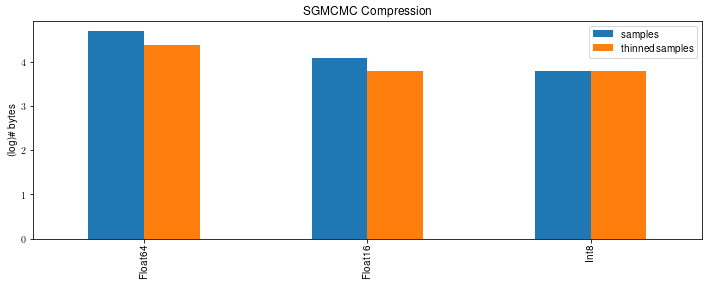

In [21]:
df_compression.plot(kind="bar",figsize=(12, 4))
plt.title("SGMCMC Compression")
plt.ylabel("(log)\# bytes")